# Deep learning for Natural Language Processing


 * Simple text representations, bag of words
 * Word embedding and... not just another word2vec this time
 * rnn for text
 * Aggregating several data sources "the hard way"
 * Solving ~somewhat~ real ML problem with ~almost~ end-to-end deep learning
 

Special thanks to Irina Golzmann for help with technical part, task prepared by Александр Панин, jheuristic@yandex-team.ru

# NLTK

You will require nltk v3.2 to solve this assignment

__It is really important that the version is 3.2, otherwize russian tokenizer might not work__

Install/update
* `sudo pip install --upgrade nltk==3.2`
* If you don't remember when was the last pip upgrade, `sudo pip install --upgrade pip`

If for some reason you can't or won't switch to nltk v3.2, just make sure that russian words are tokenized properly with RegeExpTokenizer.

# For students with low-RAM machines
 * This assignment can be accomplished with even the low-tier hardware (<= 4Gb RAM) 
 * If that is the case, turn flag "low_RAM_mode" below to True
 * If you have around 8GB memory, it is unlikely that you will feel constrained by memory.
 * In case you are using a PC from last millenia, consider setting very_low_RAM=True

In [1]:
low_RAM_mode = True
very_low_RAM = False  #If you have <3GB RAM, set BOTH to true

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset

Ex-kaggle-competition on prohibited content detection

There goes the description - https://www.kaggle.com/c/avito-prohibited-content


### Download
High-RAM mode,
 * Download avito_train.tsv from competition data files
Low-RAM-mode,
 * Download downsampled dataset from here
     * archive https://yadi.sk/d/l0p4lameqw3W8
     * raw https://yadi.sk/d/I1v7mZ6Sqw2WK (in case you feel masochistic)
 




# What's inside
Different kinds of features:
* 2 text fields - title and description
* Special features - price, number of e-mails, phones, etc
* Category and subcategory - unsurprisingly, categorical features
* Attributes - more factors

Only 1 binary target whether or not such advertisement contains prohibited materials
* criminal, misleading, human reproduction-related, etc
* diving into the data may result in prolonged sleep disorders

In [3]:
if not low_RAM_mode:
    # a lot of ram
    df = pd.read_csv("avito_train.tsv",sep='\t')
else:
    #aroung 4GB ram
    df = pd.read_csv("avito_train_1kk.tsv",sep='\t')
 

In [4]:
print df.shape, df.is_blocked.mean()
df[:5]

(1204949, 13) 0.228222107326


,itemid,category,subcategory,title,description,attrs,price,is_proved,is_blocked,phones_cnt,emails_cnt,urls_cnt,close_hours
0,10000010,Транспорт,Автомобили с пробегом,"Toyota Sera, 1991",Новая оригинальная линзованая оптика на ксенон...,"{""Год выпуска"":""1991"", ""Тип кузова"":""Купе"", ""П...",150000,NaN,0,0,0,0,0.03
1,10000094,Личные вещи,"Одежда, обувь, аксессуары",Костюм Steilmann,Юбка и топ из панбархата. Под топ трикотажная...,"{""Вид одежды"":""Женская одежда"", ""Предмет одежд...",1500,NaN,0,0,0,0,0.41
2,10000299,Личные вещи,Детская одежда и обувь,"Костюм Didriksons Boardman, размер 100, краги,...","Костюм Didriksons Boardman, в отличном состоян...","{""Вид одежды"":""Для мальчиков"", ""Предмет одежды...",3000,NaN,0,0,0,0,5.49
3,10000309,Недвижимость,Квартиры,"1-к квартира, 44 м², 9/20 эт.","В кирпичном пан.-м доме, продается одноком.-ая...","{""Тип объявления"":""Продам"", ""Количество комнат...",2642020,NaN,0,1,0,0,22.47
4,10000317,Услуги,Предложения услуг,"Поездки на таможню, печать в паспорте",Поездки на таможню гражданам СНГ для пересечен...,"{""Вид услуги"":""Деловые услуги"", ""Тип услуги"":""...",1500,0.0,1,0,0,0,1.43


![caption](https://kaggle2.blob.core.windows.net/competitions/kaggle/3929/media/Ad.png)

In [ ]:
print "Blocked ratio",df.is_blocked.mean()
print "Count:",len(df)

# Balance-out the classes
* Vast majority of data samples are non-prohibited
 * 250k banned out of 4kk
 * Let's just downsample random 250k legal samples to make further steps less computationally demanding
 * If you aim for high Kaggle score, consider a smarter approach to that.


In [ ]:
#downsample

df_0 = df.query('is_blocked==0')
df_1 = df.query('is_blocked==1')

length = min(len(df_0), len(df_1))
frames = [df_0[:length], df_1[:length]]

df = pd.concat(frames)

print "Blocked ratio:",df.is_blocked.mean()
print "Count:",len(df)

In [45]:
assert df.is_blocked.mean() < 0.51
assert df.is_blocked.mean() > 0.49
assert len(df) <= 560000

print "All tests passed"

All tests passed


In [46]:
#In case your RAM-o-meter is in the red
if very_low_ram:
    data = data[::2]

NameError: name 'very_low_ram' is not defined

# Tokenizing

First, we create a dictionary of all existing words.
Assign each word a number - it's Id

In [47]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+")

#Dictionary of tokens
token_counts = Counter()

#All texts
all_texts = np.hstack([df.description.values,df.title.values])


#Compute token frequencies
for s in all_texts:
    if type(s) is not str:
        continue
    s = s.decode('utf8').lower()
    tokens = tokenizer.tokenize(s)
    for token in tokens:
        token_counts[token] +=1


### Remove rare tokens

We are unlikely to make use of words that are only seen a few times throughout the corpora.

Again, if you want to beat Kaggle competition metrics, consider doing something better.

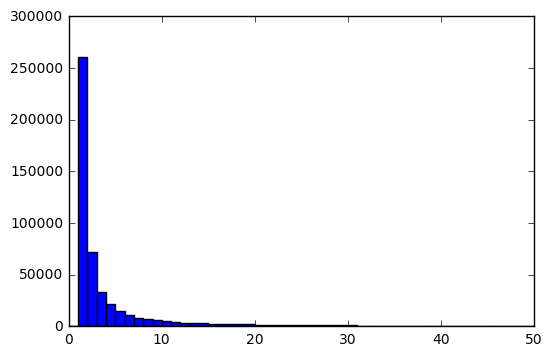

In [48]:
#Word frequency distribution, just for kicks
_=plt.hist(token_counts.values(),range=[0,50],bins=50)

In [49]:
#Select only the tokens that had at least 10 occurences in the corpora.
#Use token_counts.

min_count = 5
tokens = [token for token in token_counts.keys() if token_counts[token] > min_count]


In [50]:
print len(tokens), len(token_counts.keys())

119993 521988


In [51]:
token_to_id = {t:i+1 for i,t in enumerate(tokens)}
null_token = "NULL"
token_to_id[null_token] = 0


In [52]:
print "# Tokens:",len(token_to_id)
if len(token_to_id) < 30000:
    print "Alarm! It seems like there are too few tokens. Make sure you updated NLTK and applied correct thresholds -- unless you now what you're doing, ofc"
if len(token_to_id) > 1000000:
    print "Alarm! Too many tokens. You might have messed up when pruning rare ones -- unless you know what you're doin' ofc"

# Tokens: 119994


### Replace words with IDs
Set a maximum length for titles and descriptions.
 * If string is longer that that limit - crop it, if less - pad with zeros.
 * Thus we obtain a matrix of size [n_samples]x[max_length]
 * Element at i,j - is an identifier of word j within sample i

In [53]:
def vectorize(strings, token_to_id, max_len=150):
    token_matrix = []
    for s in strings:
        if type(s) is not str:
            token_matrix.append([0]*max_len)
            continue
        s = s.decode('utf8').lower()
        tokens = tokenizer.tokenize(s)
        token_ids = map(lambda token: token_to_id.get(token,0), tokens)[:max_len]
        token_ids += [0]*(max_len - len(token_ids))
        token_matrix.append(token_ids)

    return np.array(token_matrix)

In [54]:
desc_tokens = vectorize(df.description.values,token_to_id,max_len = 150)
title_tokens = vectorize(df.title.values,token_to_id,max_len = 15)

### Data format examples


In [55]:
print "Размер матрицы:",title_tokens.shape
for title, tokens in zip(df.title.values[:3],title_tokens[:3]):
    print title,'->', tokens[:10],'...'

Размер матрицы: (549992, 15)
Toyota Sera, 1991 -> [88299 86079 60751     0     0     0     0     0     0     0] ...
Костюм Steilmann -> [33490     0     0     0     0     0     0     0     0     0] ...
Костюм Didriksons Boardman, размер 100, краги, шап -> [33490 92066     0 49154 99859 33805     0     0     0     0] ...


__ As you can see, our preprocessing is somewhat crude. Let us see if that is enough for our network __

# Non-sequences


Some data features are not text samples. E.g. price, # urls, category, etc

They require a separate preprocessing.

In [56]:
#All numeric features
df_numerical_features = df[["phones_cnt","emails_cnt","urls_cnt","price"]]


In [57]:
#One-hot-encoded category and subcategory

from sklearn.feature_extraction import DictVectorizer

categories = df[["category","subcategory"]].to_dict('records')
data_cat_subcat = df[["category","subcategory"]].values


vectorizer = DictVectorizer(sparse=False)
cat_one_hot = vectorizer.fit_transform(categories)
cat_one_hot = pd.DataFrame(cat_one_hot,columns=vectorizer.feature_names_)

In [58]:
df_non_text = pd.merge(
    df_numerical_features,cat_one_hot,on = np.arange(len(cat_one_hot))
)
del df_non_text["key_0"]

# Split data into training and test

In [59]:
#Target variable - whether or not sample contains prohibited material
target = df.is_blocked.values.astype('int32')
#Preprocessed titles
title_tokens = title_tokens.astype('int32')
#Preprocessed tokens
desc_tokens = desc_tokens.astype('int32')

#Non-sequences
df_non_text = df_non_text.astype('float32')

In [60]:
#Split into training and test set.

from sklearn.model_selection import train_test_split

title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = train_test_split(title_tokens, desc_tokens, df_non_text, target, test_size=0.33)

## Save preprocessed data [optional]

* The next tab can be used to stash all the essential data matrices and get rid of the rest of the data.
 * Highly recommended if you have less than 1.5GB RAM left
* To do that, you need to first run it with save_prepared_data=True, then restart the notebook and only run this tab with read_prepared_data=True.

In [1]:
save_prepared_data = False #save
read_prepared_data = True #load

#but not both at once
assert not (save_prepared_data and read_prepared_data)

if save_prepared_data:
    print "Saving preprocessed data (may take up to 3 minutes)"

    import pickle
    with open("preprocessed_data.pcl",'w') as fout:
        pickle.dump((title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts), fout)
    with open("token_to_id.pcl",'w') as fout:
        pickle.dump(token_to_id,fout)

    print "готово"
    
elif read_prepared_data:
    print "Reading saved data..."
    
    import pickle
    
    with open("preprocessed_data.pcl",'r') as fin:
        data_tuple = pickle.load(fin)
    title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple
    with open("token_to_id.pcl",'r') as fin:
        token_to_id = pickle.load(fin)
        
    #Re-importing libraries to allow staring noteboook from here
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    print "done"        

Reading saved data...
done


# Train the monster

Since we have several data sources, our neural network may differ from what you used to work with.

* Separate input for titles: RNN
* Separate input for description: RNN
* Separate input for categorical features: обычные полносвязные слои или какие-нибудь трюки
 
These three inputs must be blended somehow - concatenated or added.

* Output: a simple binary classification
 * 1 sigmoidal with binary_crossentropy
 * 2 softmax with categorical_crossentropy - essentially the same as previous one
 * 1 neuron without nonlinearity (lambda x: x) +  hinge loss
 

In [2]:
#libraries
import lasagne
from theano import tensor as T
import theano

/Users/physteshka/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [3]:
#3 inputs and a refere output
title_token_ids = T.matrix("title_token_ids",dtype='int32')
desc_token_ids = T.matrix("desc_token_ids",dtype='int32')
categories = T.matrix("categories",dtype='float32')
target_y = T.ivector("is_blocked")

In [4]:
categories[:2]

Subtensor{:int64:}.0

In [5]:
import theano.tensor

def align_targets(predictions, targets):
    """Helper function turning a target 1D vector into a column if needed.
    This way, combining a network of a single output unit with a target vector
    works as expected by most users, not broadcasting outputs against targets.
    Parameters
    ----------
    predictions : Theano tensor
        Expression for the predictions of a neural network.
    targets : Theano tensor
        Expression or variable for corresponding targets.
    Returns
    -------
    predictions : Theano tensor
        The predictions unchanged.
    targets : Theano tensor
        If `predictions` is a column vector and `targets` is a 1D vector,
        returns `targets` turned into a column vector. Otherwise, returns
        `targets` unchanged.
    """
    if (getattr(predictions, 'broadcastable', None) == (False, True) and
            getattr(targets, 'ndim', None) == 1):
        targets = as_theano_expression(targets).dimshuffle(0, 'x')
    return predictions, targets

def binary_hinge_loss(predictions, targets, delta=1, log_odds=None,
                      binary=True):
    """Computes the binary hinge loss between predictions and targets.
    .. math:: L_i = \\max(0, \\delta - t_i p_i)
    Parameters
    ----------
    predictions : Theano tensor
        Predictions in (0, 1), such as sigmoidal output of a neural network
        (or log-odds of predictions depending on `log_odds`).
    targets : Theano tensor
        Targets in {0, 1} (or in {-1, 1} depending on `binary`), such as
        ground truth labels.
    delta : scalar, default 1
        The hinge loss margin
    log_odds : bool, default None
        ``False`` if predictions are sigmoid outputs in (0, 1), ``True`` if
        predictions are sigmoid inputs, or log-odds. If ``None``, will assume
        ``True``, but warn that the default will change to ``False``.
    binary : bool, default True
        ``True`` if targets are in {0, 1}, ``False`` if they are in {-1, 1}
    Returns
    -------
    Theano tensor
        An expression for the element-wise binary hinge loss
    Notes
    -----
    This is an alternative to the binary cross-entropy loss for binary
    classification problems.
    Note that it is a drop-in replacement only when giving ``log_odds=False``.
    Otherwise, it requires log-odds rather than sigmoid outputs. Be aware that
    depending on the Theano version, ``log_odds=False`` with a sigmoid
    output layer may be less stable than ``log_odds=True`` with a linear layer.
    """
    if log_odds is None:  # pragma: no cover
        raise FutureWarning(
                "The `log_odds` argument to `binary_hinge_loss` will change "
                "its default to `False` in a future version. Explicitly give "
                "`log_odds=True` to retain current behavior in your code, "
                "but also check the documentation if this is what you want.")
        log_odds = True
    if not log_odds:
        predictions = theano.tensor.log(predictions / (1 - predictions))
    if binary:
        targets = 2 * targets - 1
    predictions, targets = align_targets(predictions, targets)
    return theano.tensor.nnet.relu(delta - predictions * targets)


# NN architecture

In [6]:
title_inp = lasagne.layers.InputLayer((None, title_tr.shape[1]),input_var=title_token_ids)
descr_inp = lasagne.layers.InputLayer((None, desc_tr.shape[1]),input_var=desc_token_ids)
cat_inp = lasagne.layers.InputLayer((None, nontext_tr.shape[1]), input_var=categories)

In [7]:
from lasagne.nonlinearities import *
# Descriptions

#word-wise embedding. We recommend to start from some 64 and improving after you are certain it works.

descr_nn = lasagne.layers.EmbeddingLayer(descr_inp,
                                         input_size=len(token_to_id),
                                         output_size=128)


#reshape from [batch, time, unit] to [batch,unit,time] to allow 1d convolution over time
descr_nn = lasagne.layers.DimshuffleLayer(descr_nn, [0,2,1])

descr_nn = lasagne.layers.Conv1DLayer(descr_nn, 256, 5)

descr_nn = lasagne.layers.MaxPool1DLayer(descr_nn, 2)

descr_nn = lasagne.layers.Conv1DLayer(descr_nn, 256, 5)

descr_nn = lasagne.layers.GlobalPoolLayer(descr_nn,T.max)


# Titles

title_nn = lasagne.layers.EmbeddingLayer(title_inp,
                                         input_size=len(token_to_id),
                                         output_size=128)


#reshape from [batch, time, unit] to [batch,unit,time] to allow 1d convolution over time
title_nn = lasagne.layers.DimshuffleLayer(title_nn, [0,2,1])

title_nn = lasagne.layers.Conv1DLayer(title_nn, 128, 3)

title_nn = lasagne.layers.MaxPool1DLayer(title_nn, 2)

title_nn = lasagne.layers.Conv1DLayer(title_nn, 128, 3)

#pool over time
title_nn = lasagne.layers.GlobalPoolLayer(title_nn,T.max)

# Non-sequences
cat_nn = lasagne.layers.DenseLayer(cat_inp, 256)



In [8]:
nn = lasagne.layers.ConcatLayer([descr_nn, title_nn, cat_nn])                              

nn = lasagne.layers.DenseLayer(nn, num_units=1048)
nn = lasagne.layers.DropoutLayer(nn,p=0.3)
nn = lasagne.layers.DenseLayer(nn,1,nonlinearity=lasagne.nonlinearities.linear)

In [9]:
nn

# Loss function

* The standard way:
 * prediction
 * loss
 * updates
 * training and evaluation functions
 
 
* Hinge loss
 * $ L_i = \max(0, \delta - t_i p_i) $
 * delta is a tunable parameter: how far should a neuron be in the positive margin area for us to stop bothering about it
 * Function description may mention some +-1  limitations - this is not neccessary, at least as long as hinge loss has a __default__ flag `binary = True`

In [10]:
#All trainable params
weights = lasagne.layers.get_all_params(nn,trainable=True)
print weights

[W, W, b, W, b, W, W, b, W, b, W, b, W, b, W, b]


In [11]:

#Simple NN prediction
prediction = lasagne.layers.get_output(nn)[:,0]

#Hinge loss
loss = binary_hinge_loss(prediction,target_y, delta = 1, log_odds=True).mean()

/Users/physteshka/anaconda2/lib/python2.7/site-packages/lasagne/theano_extensions/conv.py:66: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


In [12]:
#Weight optimization step
#updates = lasagne.updates.nesterov_momentum(loss, weights, learning_rate=0.01, momentum=0.9)
updates = lasagne.updates.adam(loss, weights)

### Determinitic prediction 
 * In case we use stochastic elements, e.g. dropout or noize
 * Compile a separate set of functions with deterministic prediction (deterministic = True)
 * Unless you think there's no neet for dropout there ofc. Btw is there?

In [13]:
#deterministic version
det_prediction = lasagne.layers.get_output(nn,deterministic=True)[:,0]

#equivalent loss function
det_loss = binary_hinge_loss(prediction,target_y,delta = 1, log_odds=True).mean()

### Coffee-lation

In [14]:
train_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[loss,prediction],updates = updates)
eval_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[det_loss,det_prediction])

# Training loop
* The regular way with loops over minibatches
* Since the dataset is huge, we define epoch as some fixed amount of samples isntead of all dataset

In [15]:
#average precision at K

from oracle import APatK, score

In [16]:
# Out good old minibatch iterator now supports arbitrary amount of arrays (X,y,z)

def iterate_minibatches(*arrays,**kwargs):
    batchsize=kwargs.get("batchsize",100)
    shuffle = kwargs.get("shuffle",True)
    
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [arr.iloc[excerpt, :] if type(arr) == pd.core.frame.DataFrame else arr[excerpt] for arr in arrays]

### Tweaking guide

* batch_size - how many samples are processed per function call
  * optimization gets slower, but more stable, as you increase it.
  * May consider increasing it halfway through training
* minibatches_per_epoch - max amount of minibatches per epoch
  * Does not affect training. Lesser value means more frequent and less stable printing
  * Setting it to less than 10 is only meaningfull if you want to make sure your NN does not break down after one epoch
* n_epochs - total amount of epochs to train for
  * `n_epochs = 10**10` and manual interrupting is still an option


Tips:

* With small minibatches_per_epoch, network quality may jump around 0.5 for several epochs

* AUC is the most stable of all three metrics

* Average Precision at top 2.5% (APatK) - is the least stable. If batch_size*minibatches_per_epoch < 10k, it behaves as a uniform random variable.

* Plotting metrics over training time may be a good way to analyze which architectures work better.

* Once you are sure your network aint gonna crash, it's worth letting it train for a few hours of an average laptop's time to see it's true potential

In [17]:
from sklearn.metrics import roc_auc_score, accuracy_score

n_epochs = 50
batch_size = 100
minibatches_per_epoch = 100

for i in range(n_epochs):
    print "Epoch № ", i
    #training
    epoch_y_true = []
    epoch_y_pred = []
    
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_tr,title_tr,nontext_tr,target_tr,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch:break
            
        loss,pred_probas = train_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)
    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Train:"
    print '\tloss:',b_loss/b_c
    print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.)
    print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
    print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)
    
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_ts,title_ts,nontext_tr,target_ts,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch: break
        loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Val:"
    print '\tloss:',b_loss/b_c
    print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.)
    print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
    print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

Epoch №  0
Train:
	loss: 5688.60708027
	acc: 0.625643564356
	auc: 0.673821673012
	ap@k: 0.0991354206002
Val:
	loss: 9840.63529255
	acc: 0.543267326733
	auc: 0.557542662651
	ap@k: 0.91420342628
Epoch №  1
Train:
	loss: 47704.3241396
	acc: 0.634356435644
	auc: 0.659482356355
	ap@k: 0.0426135883172
Val:
	loss: 10190.9532372
	acc: 0.727722772277
	auc: 0.73407313948
	ap@k: 0.997252838091
Epoch №  2
Train:
	loss: 26846.4703765
	acc: 0.73198019802
	auc: 0.721376801706
	ap@k: 0.105809160013
Val:
	loss: 14905.2628587
	acc: 0.717821782178
	auc: 0.754167091627
	ap@k: 1.0
Epoch №  3
Train:
	loss: 3577.90223434
	acc: 0.804653465347
	auc: 0.867917352471
	ap@k: 0.476927044063
Val:
	loss: 30888.5634252
	acc: 0.773366336634
	auc: 0.805689338154
	ap@k: 0.998153077152
Epoch №  4
Train:
	loss: 4678.59877092
	acc: 0.82801980198
	auc: 0.885698075173
	ap@k: 0.318141159679
Val:
	loss: 22477.3531932
	acc: 0.792871287129
	auc: 0.81397051439
	ap@k: 0.981605695209
Epoch №  5
Train:
	loss: 8338.84459632
	acc: 0.84

In [20]:
print "If you are seeing this, it's time to backup your notebook. No, really, 'tis too easy to mess up everything without noticing. "

If you are seeing this, it's time to backup your notebook. No, really, 'tis too easy to mess up everything without noticing. 


In [22]:
with open("nn.pcl",'w') as fout:
    pickle.dump(nn,fout)

In [25]:
with open("nn.pcl",'r') as fin:
        token_to_id = pickle.load(fin)

# Final evaluation
Evaluate network over the entire test set

In [26]:
#evaluation
epoch_y_true = []
epoch_y_pred = []

b_c = b_loss = 0
for j, (b_desc,b_title,b_cat, b_y) in enumerate(
    iterate_minibatches(desc_ts,title_ts,nontext_tr,target_ts,batchsize=batch_size,shuffle=True)):
    loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(pred_probas)


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)

final_accuracy = accuracy_score(epoch_y_true,epoch_y_pred>0)
final_auc = roc_auc_score(epoch_y_true,epoch_y_pred)
final_apatk = APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

print "Scores:"
print '\tloss:',b_loss/b_c
print '\tacc:',final_accuracy
print '\tauc:',final_auc
print '\tap@k:',final_apatk
score(final_accuracy,final_auc,final_apatk)

Scores:
	loss: 16892.878466
	acc: 0.845821389195
	auc: 0.892595879439
	ap@k: 0.707265652783

AUC:
	Ты на правильном пути! (not ok)

Accuracy:
Надо бы подтянуть. (not ok)

Average precision at K:
	Надо бы поднажать (not ok)


# Main task

* https://goo.gl/forms/eJwIeAbjxzVuo6vn1
* Feel like Le'Cun:
 * accuracy > 0.95
 * AUC > 0.97
 * Average Precision at (test sample size * 0.025) > 0.99
 * And perhaps even farther

* Casual mode
 * accuracy > 0.90
 * AUC > 0.95
 * Average Precision at (test sample size * 0.025) > 0.92

* Remember the training, Luke
 * Dropout, regularization
 * Mommentum, RMSprop, ada*
 * etc etc etc
 
 * If you have background in texts, there may be a way to improve tokenizer, add some lemmatization, etc etc.
 * In case you know how not to shoot yourself in the foot with RNNs, they too may be of some use.